In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
import pandas as pd
from tqdm import tqdm
import webdataset as wds

import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenCLIPEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False)
device = accelerator.device
print("device:",device)

LOCAL RANK  0
device: cuda


# Data

## New Design

In [2]:
sub = "sub-001"
session = "ses-02"
n_runs = 16

filename = f"csv/{sub}_{session}.csv"
print(filename)
data = pd.read_csv(filename)
images = data['current_image'].values[14:] # note: used to be [23:] in the earlier scans
starts = data['trial.started'].values[14:]
is_new_run = data['is_new_run'].values[14:]

unique_images = np.unique(images.astype(str))
unique_images = unique_images[(unique_images!="nan")]
unique_images = unique_images[(unique_images!="blank.jpg")]
len_unique_images = len(unique_images)
print("len_unique_images",len_unique_images)
print("n_runs",n_runs)

print(images[:4])
print(starts[:4])
print(is_new_run[:4])

image_idx = np.array([])
for i in range(len(images)):
    if images[i] == "blank.jpg":
        continue
    if str(images[i]) == "nan":
        continue

    image_idx_ = np.where(images[i]==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
image_idx = torch.Tensor(image_idx).long()

/weka/proj-fmri/paulscotti/MindEyeV2/src/rtmindeye/csv/sub-001.csv
len_unique_images 851
n_runs 16
['images/image_686_seed_1.png' 'images/image_262_seed_1.png'
 'images/image_508_seed_1.png' 'images/image_671_seed_1.png']
[742.49907775 746.4931488  750.48907224 754.489129  ]
[0. 0. 0. 0.]


In [3]:
unique_images_pairs = [
    (0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11),
    (12, 13), (14, 15), (16, 17), (18, 19), (20, 21),
    (22, 23), (24, 25), (26, 27), (28, 29), (30, 31),
    (32, 33), (34, 35), (36, 37), (38, 39), (40, 41),
    (42, 43), (44, 45), (46, 47), (48, 49),
]
print(unique_images[unique_images_pairs])

In [4]:
import imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    # im = imageio.imread(f"rtmindeye_stimuli/{(unique_images[im_name]).split('/')[-1]}")
    im = imageio.imread(f"{unique_images[im_name]}")
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if ("MST_pairs" in unique_images[im_name]): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
        MST_images.append(True)
    else:
        MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("MST_images", len(MST_images))
print("MST_images==True", len(MST_images[MST_images==True]))

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_737884/3490374544.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(f"rtmindeye_stimuli/{(unique_images[im_name]).split('/')[-1]}")
/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PI

images torch.Size([1000, 3, 224, 224])
MST_images 1000
MST_images==True 100


In [5]:
pairs = utils.find_paired_indices(image_idx)
pairs = np.array(sorted(pairs, key=lambda x: x[0]))

In [6]:
glmsingle = np.load(f"glmsingle_{session}/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) 

vox = glmsingle['betasmd'].T
print("vox", vox.shape)

if vox.ndim==4:
    vox = vox[:,0,0]
    print("vox", vox.shape)

vox (1000, 165240)


Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[   2.     0.     0.   -73.5]
 [   0.     2.     0.  -109. ]
 [   0.     0.     2.   -57. ]
 [   0.     0.     0.     1. ]]

There are 165240.0 voxels in the included brain mask



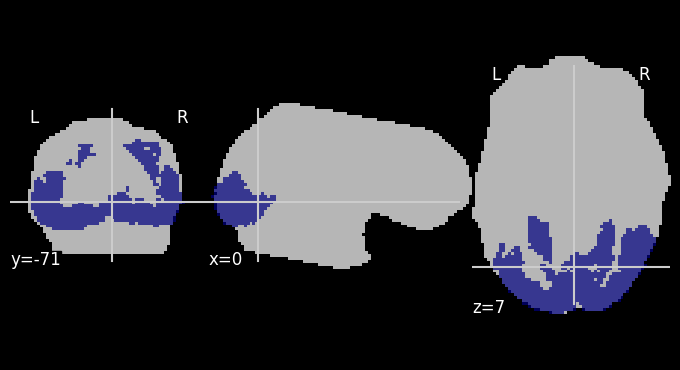

In [7]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi

# avg_mask=nib.load(f'{sub}_ses-01_brain.nii.gz')
avg_mask=nib.load(f'masks/{sub}_{session}_brain.nii.gz')

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')

roi = nib.load(f'masks/{sub}_nsdgeneral.nii.gz')

plot_roi(roi, bg_img=avg_mask)

In [8]:
avg_mask = avg_mask.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(avg_mask.sum())}")

roi = roi.get_fdata()
roi = roi.flatten()
roi = roi[avg_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

total voxels (whole brain) = 165240
nsdgeneral voxels = 18419


In [9]:
# ROI masking?
print(f"vox before ROI exclusion: {vox.shape}")
vox = vox = vox[:,roi]
print(f"vox after ROI exclusion: {vox.shape}")

if np.any(np.isnan(vox)):
    print("NaNs found! Removing voxels...")
    x,y = np.where(np.isnan(vox))
    vox = vox[:,np.setdiff1d(np.arange(vox.shape[-1]), y)]

vox after ROI exclusion: (1000, 18419)


In [10]:
vox_pairs = vox[pairs]
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
print("rels", rels.shape)

100%|██████████████████████████████████| 18419/18419 [00:00<00:00, 19317.14it/s]

rels (18419,)


In [11]:
# Reliability thresholding?
print(f"\nvox before reliability thresholding: {vox.shape}")
vox = vox[:,rels>.2]
print(f"\nvox after reliability thresholding: {vox.shape}")

In [12]:
print(images.shape)
print(vox.shape)

torch.Size([1000, 3, 224, 224])
(1000, 3428)


In [13]:
utils.seed_everything(0)

# # train = all images except images that were repeated
# # test = average of the same-image presentations
# imageTrain = np.arange(len(images))
# train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
# test_image_indices = pairs
# print(len(train_image_indices), len(test_image_indices))

# non-MST images are the train split
# MST images are the test split
train_image_indices = np.where(MST_images==False)[0]
test_image_indices = np.where(MST_images==True)[0]
print(len(train_image_indices), len(test_image_indices))

700 150


In [14]:
train_mean = np.mean(vox[train_image_indices],axis=0)
train_std = np.std(vox[train_image_indices],axis=0)

vox = utils.zscore(vox,train_mean=train_mean,train_std=train_std)
print("voxels have been zscored")
print(vox[:,0].mean(), vox[:,0].std())
print("vox", vox.shape)

images = torch.Tensor(images)
vox = torch.Tensor(vox)

voxels have been zscored
-0.020418098 0.9553846
vox (1000, 3428)


In [15]:
test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

# Model

In [16]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "sub-001_bs24_4gpu" #"sub-001_bs24_MST" #"sub-001_bs24_4gpu"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} --subj=1 \
                    --no-blurry_recon --use_prior \
                    --hidden_dim=1024 --n_blocks=4"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: sub-001_bs24_4gpu
--data_path=/weka/proj-fmri/shared/mindeyev2_dataset                     --model_name=sub-001_bs24_4gpu --subj=1                     --no-blurry_recon --use_prior                     --hidden_dim=1024 --n_blocks=4


In [17]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

In [18]:
subj_list = [subj]
subj = subj_list[0]
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Loaded test dl for subj1!



In [19]:
test_voxels, test_images = None, None
for test_i, behav in enumerate(test_dl):
    behav = behav[0]

    if behav.ndim==2:
        test_image = images[behav[:,0].long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()].mean(1)
    else:
        test_image = images[behav.long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()]
    
    if test_voxels is None:
        test_voxels = test_vox
        test_images = test_image
    else:
        test_voxels = torch.vstack((test_voxels, test_vox))
        test_images = torch.vstack((test_images, test_image))

print(test_i, len(test_voxels), len(test_images))

0 150 150


In [20]:
num_voxels_list = []
num_voxels_list.append(test_voxels.shape[-1])

In [21]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [22]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len=1): 
        super(RidgeRegression, self).__init__()
        self.seq_len = seq_len
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(self.seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=1, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
3,511,296 total
3,511,296 trainable
param counts:
3,511,296 total
3,511,296 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
456,871,576 total
456,871,576 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
716,736,792 total
716,736,776 trainable


In [23]:
# Load pretrained model ckpt
tag='last'
outdir = os.path.abspath(f'../../train_logs/{model_name}')
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
del checkpoint
print("ckpt loaded!")


---loading /weka/proj-fmri/paulscotti/MindEyeV2/train_logs/sub-001_bs24_4gpu/last.pth ckpt---

[2024-08-07 12:47:24,185] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
ckpt loaded!


In [24]:
# prep unCLIP
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = '/weka/proj-medarc/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [25]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb
processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
clip_text_seq_dim = 257
clip_text_emb_dim = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load("../bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

In [26]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

all_blurryrecons = None
all_images = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None
all_prior_out = None
all_backbones = None

minibatch_size = 32
num_samples_per_image = 1
plotting = False

with torch.no_grad():
    for batch in tqdm(range(0,len(test_images),minibatch_size)):
        start_time = time.time() 

        image = test_images[batch:batch+minibatch_size]
        voxel = test_voxels[batch:batch+minibatch_size].unsqueeze(1).to(device)

        # Save ground truth images
        if all_images is None:
            all_images = image
        else:
            all_images = torch.vstack((all_images, image))
        
        voxel_ridge = model.ridge(voxel,0)
        backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
                
        # Save retrieval submodule outputs
        if clip_scale>0:
            if all_clipvoxels is None:
                all_clipvoxels = clip_voxels.cpu()
            else:
                all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
                
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20).cpu()
        
        if all_prior_out is None:
            all_prior_out = prior_out
        else:
            all_prior_out = torch.vstack((all_prior_out, prior_out))

        pred_caption_emb = clip_convert(prior_out.to(device).float())
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        if plotting:
            jj=-1
            fig, axes = plt.subplots(1, 12, figsize=(10, 4))

        for i in range(len(voxel)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
                
            if plotting:  
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(image[i]))
                axes[jj].axis('off')
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(samples.cpu()[0]))
                axes[jj].axis('off')
        
        plt.show()

        print(model_name)
        err # dont actually want to run the whole thing with plotting=True

# resize outputs before saving
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images).float()
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if blurry_recon: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
        
## Saving ##
if "MST" in model_name:
    np.save(f"evals/{model_name}/{model_name}_MST_ID.npy", MST_ID)
torch.save(all_images.cpu(),f"evals/{model_name}/{model_name}_all_images.pt")
torch.save(all_recons,f"evals/{model_name}/{model_name}_all_recons.pt")
if clip_scale>0:
    torch.save(all_clipvoxels,f"evals/{model_name}/{model_name}_all_clipvoxels.pt")
torch.save(all_prior_out,f"evals/{model_name}/{model_name}_all_prior_out.pt")
torch.save(all_predcaptions,f"evals/{model_name}/{model_name}_all_predcaptions.pt")
print(f"saved {model_name} outputs!")

  0%|                                                     | 0/5 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a snowboarder is skiing down a hill.', 'a man is holding a camera.', 'a man on a surfboard in the water.', 'a man on a surfboard in the water.', 'a man is sitting down and looking at the camera.', 'a plate with a plate with food on it', 'a man standing in front of a building.', 'a large blue sky.', 'a large body of water.', 'a man riding a bike on a dirt road.', 'a man riding a surfboard on top of a wave.', 'a man standing on a sidewalk next to a fence.', 'a man standing on top of a surfboard.', 'a plane is flying in the air.', 'a man standing on a snow covered slope.', 'a car driving down a street.', 'a giraffe standing next to a tree.', 'a baseball player is standing on a field.', 'a man standing next to a building.', 'a white wall', 'a kitchen with a lot of furniture.', 'a man standing on a surfboard next to a surfboard.', 'a building with a clock on it', 'a skier is skiing down a hill.', 'a man on a surfboard in the water.', 'a snowboarder is riding down a hill.', 'a dog is walki

/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 20%|████████▊                                   | 1/5 [02:59<11:57, 179.47s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a bathroom with a toilet and a sink.', 'a man riding a skateboard on top of a snow covered slope.', 'a snowboarder is skiing down a hill.', 'a plate of food', 'a street sign and a street sign', 'a zebra standing in a field.', 'a skateboarder is riding down a sidewalk.', 'a baseball player is standing on a field.', 'a view of a room.', 'a train is parked on the side of the road.', 'a large area of grass.', 'a street with a car and a bus', 'a man sitting down next to a table.', 'a man standing on a tennis court.', "a young girl is holding a small child's hand.", 'a man standing on a skateboard.', 'a toilet with a lid open.', 'a clock on a building.', 'a group of people sitting around a table.', 'a man riding a surfboard on top of a wave.', 'a zebra standing in a field.', 'a room with a view', 'a baseball player is standing on a field.', 'a herd of cattle grazing on a lush green field.', 'a woman standing in front of a table.', 'a large body of water', 'a table with a plate of food on i

 40%|█████████████████▌                          | 2/5 [05:59<08:59, 179.69s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man on a beach with a surfboard.', 'a man standing next to a table.', 'a large building with a lot of windows.', 'a man sitting down next to a table.', 'a man riding a skateboard down a snow covered slope.', 'a large room with a lot of furniture.', 'a bathroom with a toilet and a sink.', 'a street sign with a sign on it.', 'a large group of people.', 'a man standing next to a building.', 'a counter with a lot of items on it', 'a man riding a skateboard on top of a sidewalk.', 'a bus driving down a street.', 'a plate with a plate with food on it', 'a street with a car and a street with a lot of cars.', 'a large boat on a lake.', 'a man standing next to a woman.', 'a herd of cattle grazing on a field.', 'a dog is standing in the grass.', 'a large room with a lot of furniture.', 'a plate of food with a knife.', 'a kitchen with a counter top and a sink in the background.', 'a man on a snowboard in a field.', 'a street with a lot of cars and a building.', 'a man and a woman are sitting 

 60%|██████████████████████████▍                 | 3/5 [08:57<05:57, 178.88s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person sitting down on a table.', 'a bathroom with a toilet and a sink.', 'a plate with a plate with a plate with a plate with a plate with a plate with a', 'a man standing on a field.', 'a group of people standing around.', 'a large building with a lot of windows.', 'a table with a plate and a plate on it', 'a surfer on a surfboard.', 'a man standing on top of a field.', 'a woman standing in front of a building.', 'a large elephant in a pond.', 'a man on a beach with a surfboard.', 'a man standing on a field.', 'a large body of water', 'a building with a clock on it.', 'a young man is standing in front of a camera.', 'a zebra standing on a grass covered field.', 'a street with a lot of traffic.', 'a street with a lot of cars and people.', 'a man sitting down next to a woman.', 'a plane is flying in the air.', 'a street with a car and a bus.', 'a skier is skiing on a snowy slope.', 'a room with a view', 'a baseball player is standing on a field.', 'a table with a vase and a plant o

 80%|███████████████████████████████████▏        | 4/5 [11:56<02:59, 179.22s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing on a field.', 'a large room with a lot of furniture.', 'a plate of food with a bunch of food on it.', 'a plate with a piece of food on it', 'a plate of food', 'a bus driving down a street.', 'a young man is holding a small child.', 'a plate of food with a fork.', 'a man standing on a tennis court.', 'a woman holding a fork.', 'a man standing next to a woman.', 'a table with a plate and a plate with a plate with a plate with a plate with a', 'a young man is holding a cell phone.', 'a young man holding a tennis racket.', 'a herd of zebra grazing on a field.', 'a train is driving past a train.', 'a sign that says " stop " on it.', 'a group of people playing a game of tennis.', 'a white and black wall', 'a bathroom with a toilet and a sink.', 'a plate of food with a fork.', 'a man is holding a phone.']


100%|████████████████████████████████████████████| 5/5 [14:05<00:00, 169.03s/it]
/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


saved sub-001_bs24_4gpu outputs!
